# Домашнее задание 2-2. 


# Задача 3. Posterior Sampling в задаче RL (Reinforcement Learning)

Выполнил: Чемров Кирилл Сергеевич, группа Б01-811

Преподаватели: Грабовой Андрей Валериевич, Воронцов Константин Вячеславович

# Библиотеки

In [2]:
from abc import abstractmethod

import numpy as np
import pandas as pd

from scipy.stats import gamma, norm, dirichlet

import matplotlib.pyplot as plt

# Задача о заплыве

Задача на основе марковских процесов.

https://arxiv.org/pdf/1306.0940.pdf

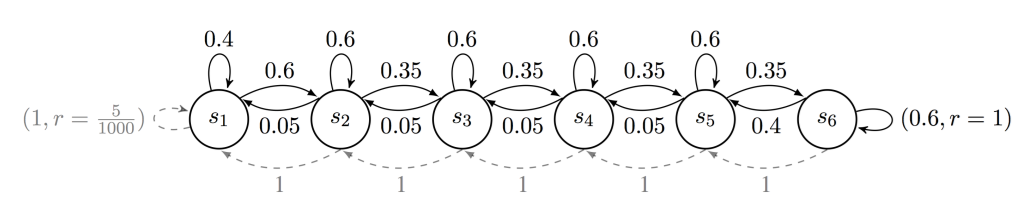


In [3]:
class RiverSwim:
    def __init__(self, 
                 isc  = 4, # число состояний (без учета крайних)
                 ms   = 16, # максимальное число шагов
                 lr   = 5/1000, 
                 rr   = 1.0, 
                 seed = 42):
        self.rs = np.random.RandomState(seed)
        self._max_steps = ms
        self._interm_states = isc

        self._steps = 0
        self._current_state = 1

        self.lr = lr
        self.rr = rr
        
    @property
    def action_count(self):
        return 2
    
    @property
    def states_count(self):
        return 2 + self._interm_states
    
    def _get_probs(self, action):
        if action == 0:
            if self._current_state == 0:
                return [0.00, 1.00, 0.00]
            else:
                return [1.00, 0.00, 0.00]
            
        elif action == 1:
            if self._current_state == 0:
                return [0.00, 0.40, 0.60]
            if self._current_state == self.states_count - 1:
                return [0.40, 0.60, 0.00]
            else:
                return [0.05, 0.60, 0.35]

    def step(self, action):
        reward = 0.0
        if self._steps >= self._max_steps:
            return self._current_state, reward, True
        
        transition = self.rs.choice(range(3), p=self._get_probs(action))
        if transition == 0:
            self._current_state -= 1
        elif transition == 1:
            pass
        else:
            self._current_state += 1

        if self._current_state == 0:
            reward = self.lr
        elif self._current_state == self.states_count - 1:
            reward = self.rr
        
        self._steps += 1
        return self._current_state, reward, False

# Q-learning метод

In [4]:
class QLearningAgent:
    def __init__(self, n, K, lr=0.2, gamma=0.95, epsilon=0.2, seed=42):
        self.rs = np.random.RandomState(seed)
        self._gamma = gamma
        self._epsilon = epsilon
        self._q_matrix = np.zeros((n, K))
        self._lr = lr

    def get_action(self, state):
        if self.rs.random() < self._epsilon:
            return self.rs.randint(0, self._q_matrix.shape[1])
        else:
            return np.argmax(self._q_matrix[state])
    
    def get_q_matrix(self):
        return self._q_matrix
        
    def start_episode(self):
        pass

    def update(self, state, action, reward, next_state):
        self._q_matrix[state, action] = self._q_matrix[state, action] + self._lr*(reward + self._gamma*np.max(self._q_matrix[next_state]) - self._q_matrix[state, action])
        return


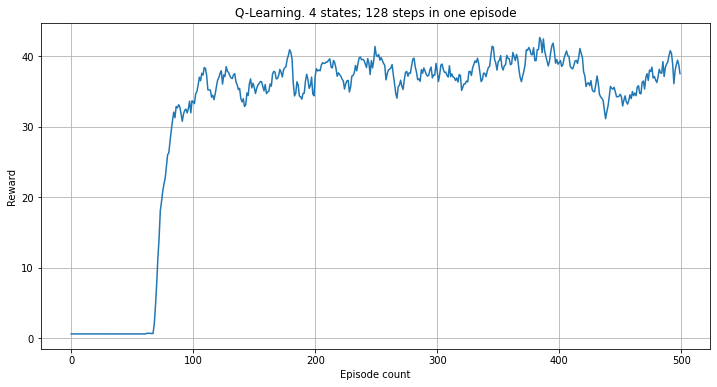

Values of state-action pairs:


<Figure size 432x288 with 0 Axes>

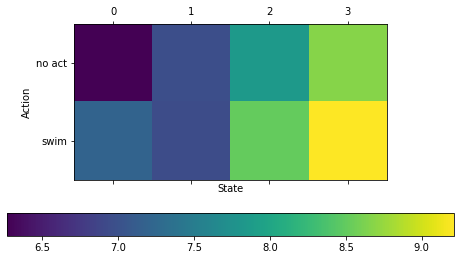

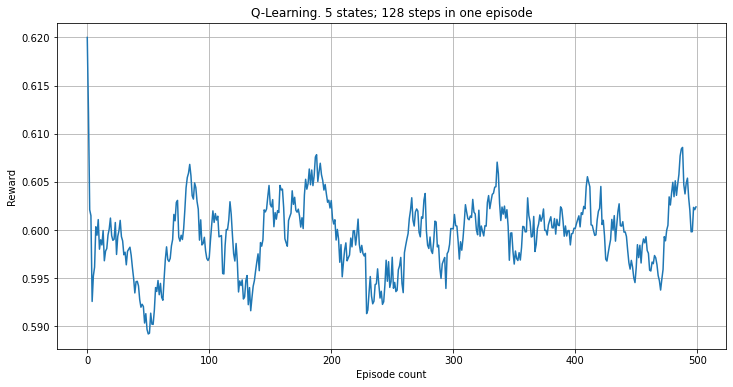

Values of state-action pairs:


<Figure size 432x288 with 0 Axes>

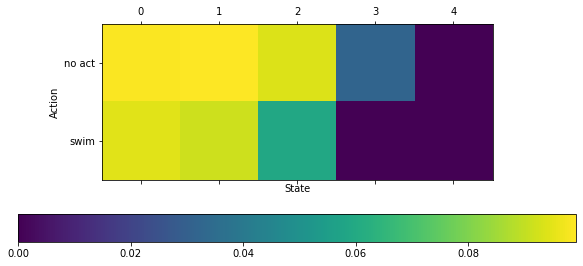

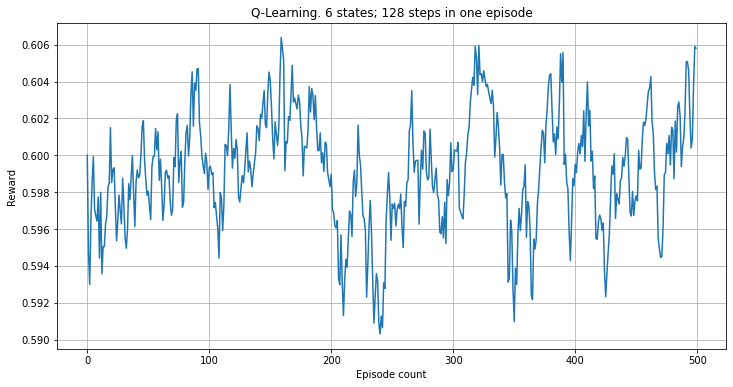

Values of state-action pairs:


<Figure size 432x288 with 0 Axes>

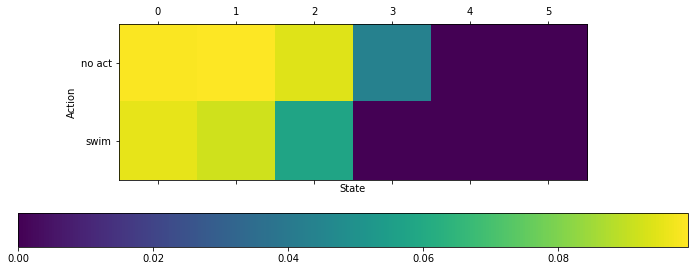

In [61]:
for n in [2,3, 4]:
    ms = 128
    episodes = 500
    actions = 2

    agent = QLearningAgent(2+n, actions)

    episode_rewards = []
    for ep in range(episodes):
        river_swim = RiverSwim(n, ms, seed=np.random.randint(0,10000))
        state, ep_reward, is_done = river_swim._current_state, 0.0, False
        agent.start_episode()
        while not is_done:
            action = agent.get_action(state)
            next_state, reward, is_done = river_swim.step(action)
            agent.update(state, action, reward, next_state)
            state = next_state
            ep_reward += reward
        episode_rewards.append(ep_reward)

    # Reward on episodes plot
    plt.figure(figsize=(12, 6))
    plt.plot(pd.DataFrame(np.array(episode_rewards)).ewm(alpha=.1).mean())
    plt.grid()
    plt.title(f"Q-Learning. {n+2} states; {ms} steps in one episode")
    plt.xlabel("Episode count")
    plt.ylabel("Reward")
    plt.show()

    # Values of state-action pairs plot
    plt.figure()
    msh = plt.matshow(agent.get_q_matrix().T)
    plt.colorbar(msh, orientation="horizontal")
    plt.yticks(ticks=[0,1], labels=['no act', 'swim'])
    plt.xlabel("State")
    plt.ylabel("Action")
    print("Values of state-action pairs:")
    plt.show()

В случае 4 состояний, Q-learning агенту удается дойти до правого края и обучиться получать большую награду, но для этого требуется порядка 70 эпизодов. Кроме того, уже для 5 состояний агент не доходит до правого края.

#Posterior Sampling

Требуется решить проблему, связанную с тем, что алгоритм не доходит до правого края и начинает всегда скатываться по течению и получать лишь небольшую награду.
Для этого предлагается реализовать метод Posterior Sampling из статьи:
[https://arxiv.org/pdf/1306.0940.pdf](https://arxiv.org/pdf/1306.0940.pdf)

Используются обозначения из разбора статьи:
[https://github.com/andriygav/MachineLearningSeminars/blob/master/sem27/main.PNG](https://github.com/andriygav/MachineLearningSeminars/blob/master/sem27/main.PNG)

In [57]:
class PSAgent:
    def __init__(self, n, K, len_of_trans=1, seed=42):
        self.rs = np.random.RandomState(seed)
        # Dimensions
        self.n = n                    # number of states
        self.K = K                    # number of actions
        # Matrix of transitions for Dirichlet distribution
        self._T = np.ones((n,n,K))    # states_i x states_f x actions
        # and matrix of Dirichlet distribution
        self._S = np.zeros((n,n,K))   # states_i x states_f x actions
        # Normal-gamma distribution parameters
        self._mu = np.ones((n,K))     # states_i x actions
        self._alpha = np.ones((n,K))  # states_i x actions
        self._beta = np.ones((n,K))   # states_i x actions
        self._nu = np.ones((n,K))     # states_i x actions
        # and matrix of normal-gamma distribution (rewards) 
        self._R = np.zeros((n,K))     # states_i x actions
        # Vector for action decision
        self._V = np.zeros(n)         # states
        # List of previos states to count transitions in matrix T
        self.prev_states = []
        self.len_of_trans = len_of_trans
    
    def get_action(self, state):  
        return np.argmax(self._R[state] + np.dot(self._S[state].T, self._V))

    def get_q_matrix(self):
        return self._R + np.dot(self._S.transpose(0,2,1), self._V)
        
    def start_episode(self):
        self.prev_states = []
        self._S = np.array([[np.random.dirichlet(t) for t in T] 
                                for T in self._T.transpose(0,2,1) ]
                                    ).reshape(self.n,self.K,self.n).transpose(0,2,1)
        t = gamma.rvs(a=self._alpha, scale=1/self._beta, random_state=self.rs)
        self._R = norm.rvs(loc=self._mu, scale=1/np.sqrt(t*self._nu), random_state=self.rs)
        self._V = np.amax(self._R + np.dot(self._S.transpose(0,2,1), self._V), axis=1)
        return

    def update(self, state, action, reward, next_state):
        self.prev_states.append(state)
        # count only transitions of length self.len_of_trans and less
        for prev_st in self.prev_states[-self.len_of_trans:]:
            self._T[prev_st, next_state, action] += 1
        self._alpha[state, action] += 1/2
        self._beta[state, action] += self._nu[state, action]/(self._nu[state, action]+1) * (reward - self._mu[state, action])**2 / 2
        self._mu[state, action] = (self._nu[state, action] * self._mu[state, action] + reward)/(self._nu[state, action]+1)
        self._nu[state, action] += 1
        return

## Примеры с короткими реками

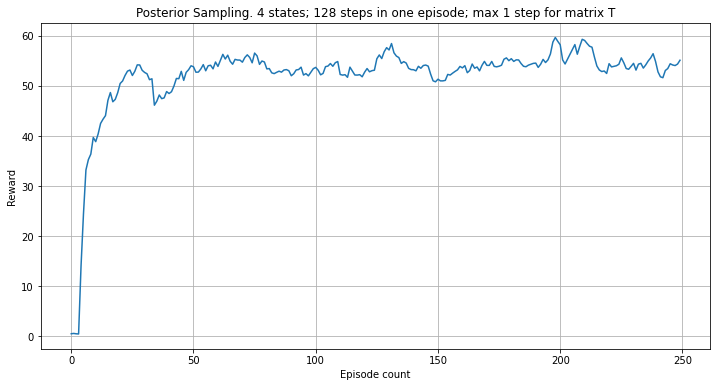

Values of state-action pairs:


<Figure size 432x288 with 0 Axes>

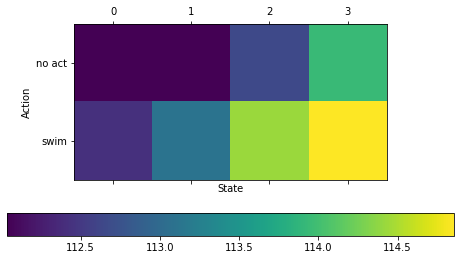

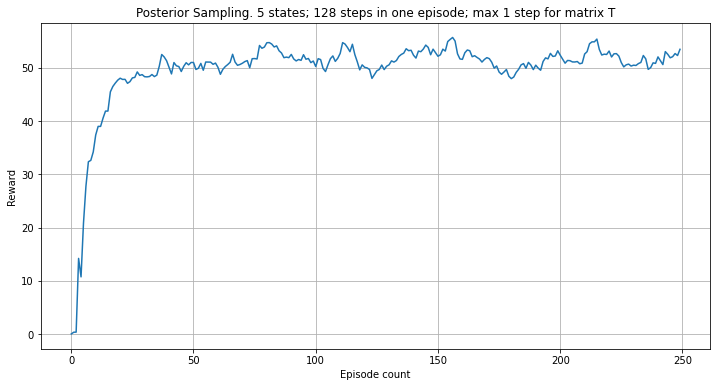

Values of state-action pairs:


<Figure size 432x288 with 0 Axes>

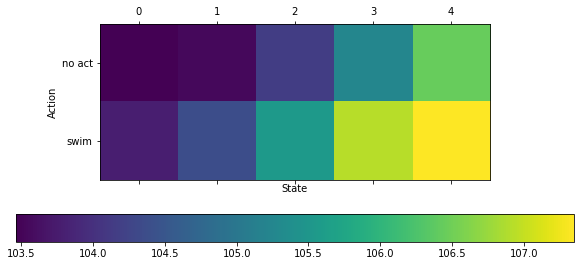

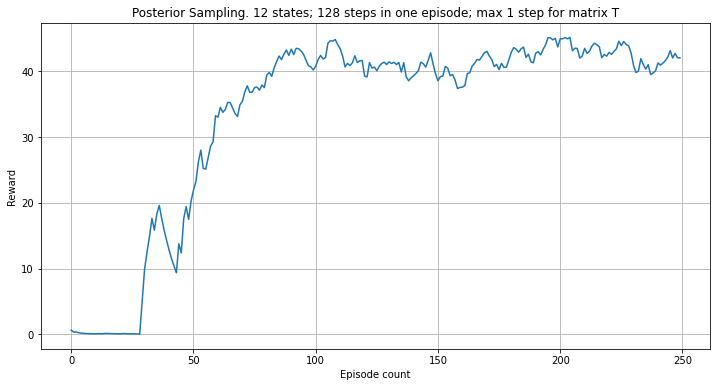

Values of state-action pairs:


<Figure size 432x288 with 0 Axes>

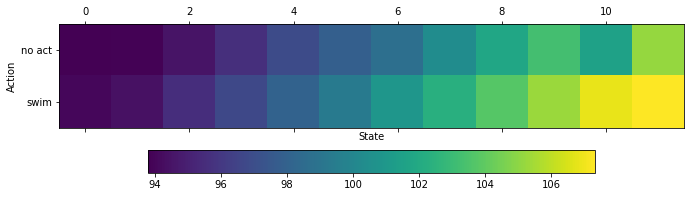

In [62]:
for n in [2, 3, 10]:
    ms = 128
    episodes = 250
    actions = 2
    agent = PSAgent(2+n, actions, seed=42)

    episode_rewards = []
    for ep in range(episodes):
        river_swim = RiverSwim(n, ms, seed=np.random.randint(0,10000))
        state, ep_reward, is_done = river_swim._current_state, 0.0, False
        agent.start_episode()
        while not is_done:
            action = agent.get_action(state)
            next_state, reward, is_done = river_swim.step(action)
            agent.update(state, action, reward, next_state)
            state = next_state
            ep_reward += reward
        episode_rewards.append(ep_reward)

    # Reward on episodes plot
    plt.figure(figsize=(12, 6))
    plt.plot(pd.DataFrame(np.array(episode_rewards)).ewm(alpha=.1).mean())
    plt.grid()
    plt.title(f"Posterior Sampling. {n+2} states; {ms} steps in one episode; max 1 step for matrix T")
    plt.xlabel("Episode count")
    plt.ylabel("Reward")
    plt.show()

    # Values of state-action pairs plot
    plt.figure()
    msh = plt.matshow(agent.get_q_matrix().T)
    plt.colorbar(msh, orientation="horizontal")
    plt.yticks(ticks=[0,1], labels=['no act', 'swim'])
    plt.xlabel("State")
    plt.ylabel("Action")
    print("Values of state-action pairs:")
    plt.show()

Агент с Posterior Sampling обучается гораздо быстрее, чем Q-learning агент, в случае 4 состояний. Кроме того, с помощью Posterior Sampling удается справиться даже с "длинной рекой". Видно, что в каждом состоянии агент предпочетает плыть, а не бездействовать, что позволяет ему получать макисмальну награду.

## Зависимость от максимальной длины переходов в матрице T
Исследуем зависимость обучения от максимальной длины переходов, которые считаются в матрице T.

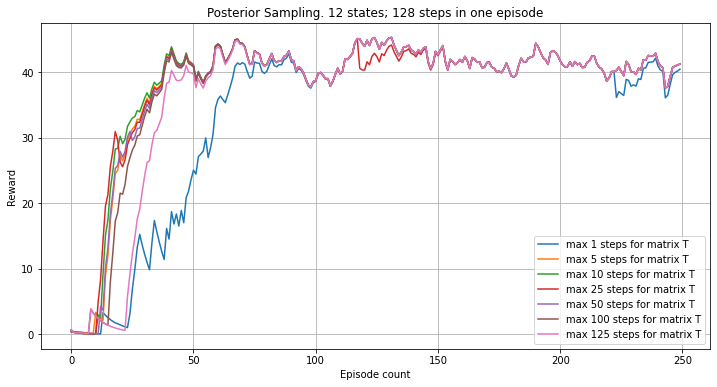

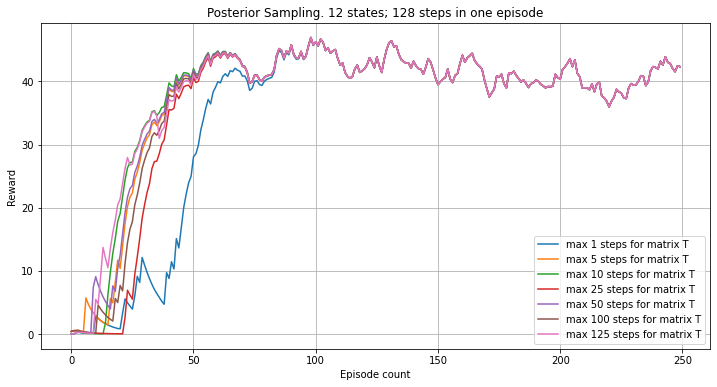

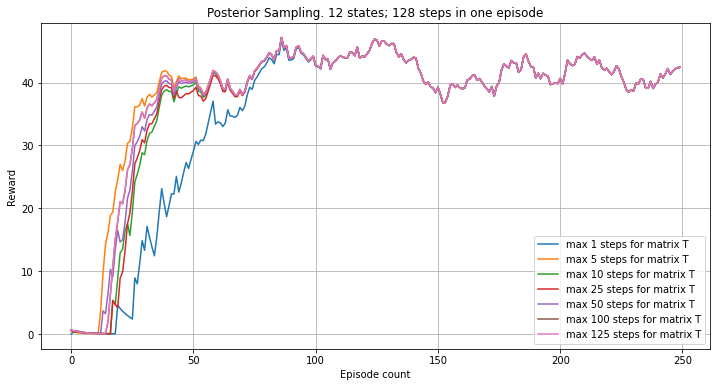

In [73]:
for PSseed in [1, 11, 111]:
    n = 10
    ms = 128
    episodes = 250
    actions = 2
    seeds = np.random.randint(0,10000, size=episodes)
    plt.figure(figsize=(12, 6))
    for len_of_trans in [1,5,10,25,50,100,125]:
        agent = PSAgent(2+n, actions, len_of_trans=len_of_trans, seed=PSseed)

        episode_rewards = []
        for ep in range(episodes):
            river_swim = RiverSwim(n, ms, seed=seeds[ep])
            state, ep_reward, is_done = river_swim._current_state, 0.0, False
            agent.start_episode()
            while not is_done:
                action = agent.get_action(state)
                next_state, reward, is_done = river_swim.step(action)
                agent.update(state, action, reward, next_state)
                state = next_state
                ep_reward += reward
            episode_rewards.append(ep_reward)
        # Reward on episodes plot
        plt.plot(pd.DataFrame(np.array(episode_rewards)).ewm(alpha=.1).mean(), label=f'max {len_of_trans} steps for matrix T')
    plt.grid()
    plt.legend(loc='best')
    plt.title(f"Posterior Sampling. {n+2} states; {ms} steps in one episode")
    plt.xlabel("Episode count")
    plt.ylabel("Reward")
    plt.show()


С поправкой на случайность можно сделать вывод, что максимальная длина переходов в матрице T слабо влияет на результат. Но учитывать всего один шаг недостаточно (обучается медленнее), поэтому лучше выбрать значение порядка 10 шагов.

## Длинная река
Попробуем еще увеличить число состояний (длину реки). Вместе с этим проварьируем количесвто шагов в одной игре, так как чем больше состояний, тем больше шагов требуется для того, чтобы дойти до правого края.

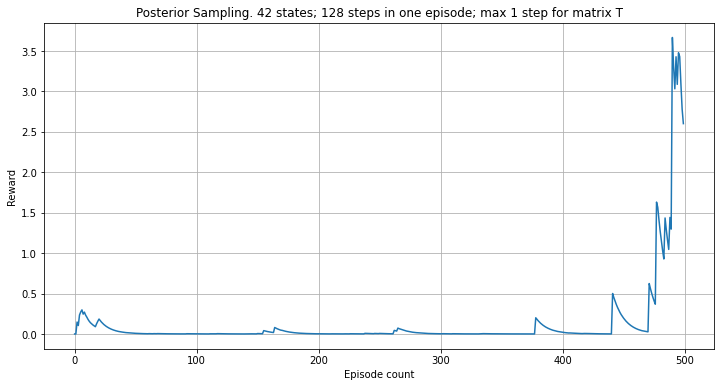

Values of state-action pairs:


<Figure size 432x288 with 0 Axes>

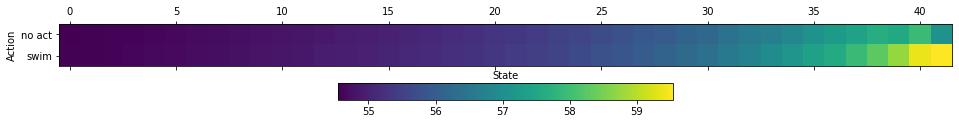

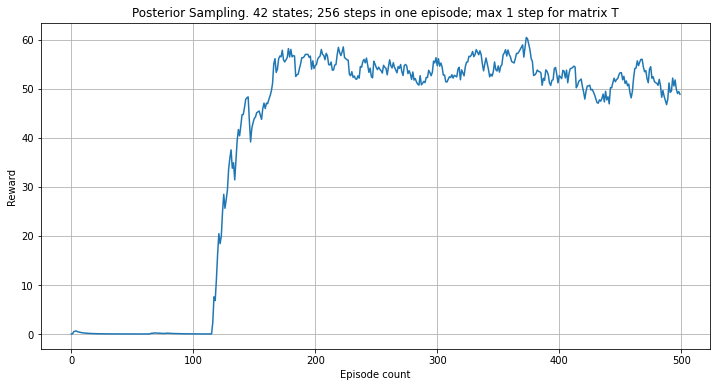

Values of state-action pairs:


<Figure size 432x288 with 0 Axes>

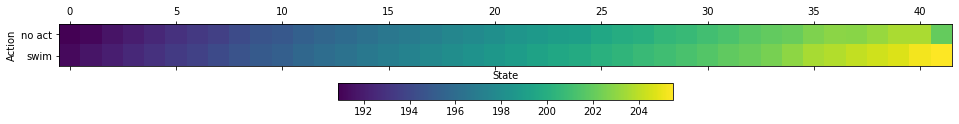

In [83]:
for ms in [128, 256]:
    n = 40
    episodes = 500
    actions = 2
    agent = PSAgent(2+n, actions, len_of_trans=10, seed=42)
    seeds = np.random.randint(0,10000, size=episodes)
    episode_rewards = []
    for ep in range(episodes):
        river_swim = RiverSwim(n, ms, seed=seeds[ep])
        state, ep_reward, is_done = river_swim._current_state, 0.0, False
        agent.start_episode()
        while not is_done:
            action = agent.get_action(state)
            next_state, reward, is_done = river_swim.step(action)
            agent.update(state, action, reward, next_state)
            state = next_state
            ep_reward += reward
        episode_rewards.append(ep_reward)

    # Reward on episodes plot
    plt.figure(figsize=(12, 6))
    plt.plot(pd.DataFrame(np.array(episode_rewards)).ewm(alpha=.1).mean())
    plt.grid()
    plt.title(f"Posterior Sampling. {n+2} states; {ms} steps in one episode; max 1 step for matrix T")
    plt.xlabel("Episode count")
    plt.ylabel("Reward")
    plt.show()

    # Values of state-action pairs plot
    plt.figure()
    msh = plt.matshow(agent.get_q_matrix().T)
    plt.colorbar(msh, orientation="horizontal")
    plt.yticks(ticks=[0,1], labels=['no act', 'swim'])
    plt.xlabel("State")
    plt.ylabel("Action")
    print("Values of state-action pairs:")
    plt.show()
    print()

Как и ожидалось, увеличение числа шагов в одной игре позволяет агенту дойплывать до правого края. Стоит отметить, что в случае такой длинной реки, оказывается очень важным максимальная длина переходов в матрице T. Ниже показано, что при длине равной 1 агент вовсе не учится плыть до правого края.

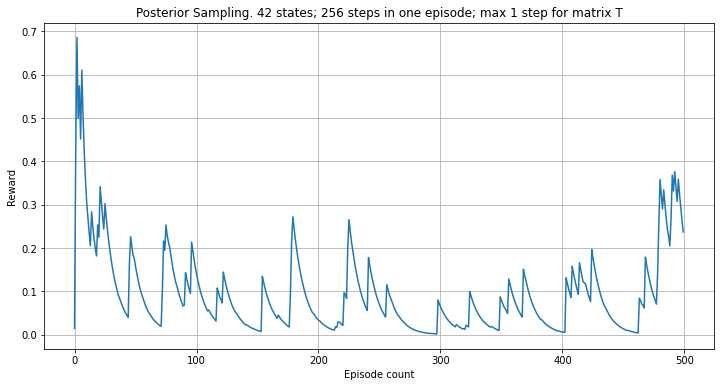

Values of state-action pairs:


<Figure size 432x288 with 0 Axes>

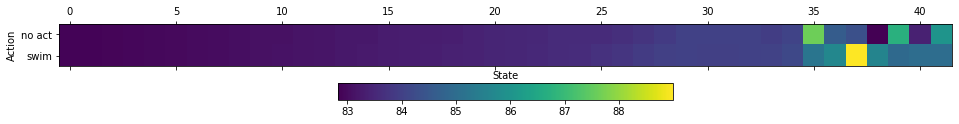

In [82]:
ms = 256
n = 40
episodes = 500
actions = 2
agent = PSAgent(2+n, actions, len_of_trans=1, seed=42)
seeds = np.random.randint(0,10000, size=episodes)
episode_rewards = []
for ep in range(episodes):
    river_swim = RiverSwim(n, ms, seed=seeds[ep])
    state, ep_reward, is_done = river_swim._current_state, 0.0, False
    agent.start_episode()
    while not is_done:
        action = agent.get_action(state)
        next_state, reward, is_done = river_swim.step(action)
        agent.update(state, action, reward, next_state)
        state = next_state
        ep_reward += reward
    episode_rewards.append(ep_reward)

# Reward on episodes plot
plt.figure(figsize=(12, 6))
plt.plot(pd.DataFrame(np.array(episode_rewards)).ewm(alpha=.1).mean())
plt.grid()
plt.title(f"Posterior Sampling. {n+2} states; {ms} steps in one episode; max 1 step for matrix T")
plt.xlabel("Episode count")
plt.ylabel("Reward")
plt.show()

# Values of state-action pairs plot
plt.figure()
msh = plt.matshow(agent.get_q_matrix().T)
plt.colorbar(msh, orientation="horizontal")
plt.yticks(ticks=[0,1], labels=['no act', 'swim'])
plt.xlabel("State")
plt.ylabel("Action")
print("Values of state-action pairs:")
plt.show()

# Выводы

В работе для решения "Задачи о заплыве" был реализован агент с Posterior Sampling, который показал лучшие результаты по сравнению с Q-Learning агентом. Posterior Sampling агент обучается быстрее и может справиться даже с длинной рекой. Кроме того, была исследована зависимость обучения от параметра, который определяет максимальную длину переходов, которая учитывается для оценки вероятности переходов из одного состояния в другое при выборе определнного действия. Для короткой реки этот параметр почти не влияет на процесс обучения, но лучше выбирать длину более 1 шага. В случае длинных рек влияние этого параметра гораздо больше, поэтому стоит внимательнее подходить к его выбору.